# Money Maker 3000 Adjusted Close Regression Model

## Import Libraries

In [2]:
from pandas_datareader import data as pdr
from datetime import date, timedelta
import yfinance as yf
import pandas as pd
from importlib import reload # for reloading helper functions after changes
import matplotlib.pyplot as plt
import helper_functions as helper
from random import randint

## Retreive Data

In [3]:
yf.pdr_override()
ticker_symbol = 'GOOGL'
start_date = "2015-01-01"
end_date = "2023-04-01"
yesterday = date.today() - timedelta(days=1) #end date set to yesterday because todays data my not be in
data = pdr.get_data_yahoo(ticker_symbol, start=start_date, end=end_date)
data.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2076 entries, 2015-01-02 to 2023-03-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2076 non-null   float64
 1   High       2076 non-null   float64
 2   Low        2076 non-null   float64
 3   Close      2076 non-null   float64
 4   Adj Close  2076 non-null   float64
 5   Volume     2076 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 113.5 KB


## Create Daily Return and Simple Moving Averages

In [4]:
data['daily_ret'] = 100.0 * ((data['Adj Close'] / data['Adj Close'].shift(1)) - 1)
helper.get_set_sma(data)
data.dropna(inplace=True)
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
daily_ret    0
sma_7        0
sma_30       0
sma_50       0
dtype: int64

In [5]:
data

,Open,High,Low,Close,Adj Close,Volume,daily_ret,sma_7,sma_30,sma_50
Date,,,,,,,,,,
2015-03-16,27.846500,28.187500,27.566000,28.082001,28.082001,36856000,1.562391,28.131072,27.551084,26.84904
2015-03-17,27.914499,28.032000,27.720501,27.880501,27.880501,28892000,-0.717541,28.021857,27.593434,26.87710
2015-03-18,27.886499,28.325500,27.674999,28.308001,28.308001,35324000,1.533329,27.965143,27.648200,26.92380
2015-03-19,28.226000,28.348000,28.106001,28.183500,28.183500,24660000,-0.439806,27.992429,27.710817,26.98083
2015-03-20,28.335501,28.355000,28.224001,28.247499,28.247499,44320000,0.227080,28.058572,27.769350,27.04063
...,...,...,...,...,...,...,...,...,...,...
2023-03-27,104.620003,104.760002,101.930000,102.459999,102.459999,31120900,-2.826255,103.518572,95.594000,96.62480
2023-03-28,102.440002,102.449997,99.739998,101.029999,101.029999,32057900,-1.395667,103.434286,95.808000,96.80300
2023-03-29,102.279999,102.489998,100.650002,101.389999,101.389999,28779600,0.356330,103.458571,96.031667,97.00500


## Reduce Feature Set to most useful features
### Determination of which features to use and which to drop has been ommited from this notebook to prevent cluttered code and improve explainablity

In [6]:
features_to_drop = ['Open', 'High', 'Low', 'Close', 'sma_30', 'sma_50']
data_trimmed = data.drop(features_to_drop, axis=1)
data_trimmed

,Adj Close,Volume,daily_ret,sma_7
Date,,,,
2015-03-16,28.082001,36856000,1.562391,28.131072
2015-03-17,27.880501,28892000,-0.717541,28.021857
2015-03-18,28.308001,35324000,1.533329,27.965143
2015-03-19,28.183500,24660000,-0.439806,27.992429
2015-03-20,28.247499,44320000,0.227080,28.058572
...,...,...,...,...
2023-03-27,102.459999,31120900,-2.826255,103.518572
2023-03-28,101.029999,32057900,-1.395667,103.434286
2023-03-29,101.389999,28779600,0.356330,103.458571


## Split data for K fold validation using 5 folds

In [7]:
number_of_days = int(data_trimmed.shape[0]/5)
data_split = list()
data_split.append(data_trimmed[0 : number_of_days]) 
data_split.append(data_trimmed[number_of_days : 2* number_of_days])
data_split.append(data_trimmed[2*number_of_days : 3*number_of_days])
data_split.append(data_trimmed[3*number_of_days : 4*number_of_days])
data_split.append(data_trimmed[4*number_of_days : 5*number_of_days])



## Create 5 days worth of lag features for each date

In [8]:
reload(helper)

data_target1 = data_split[0]['Adj Close'].drop(data_split[0].head(5).index)
data_split[0] = helper.create_lags(data_split[0],5,0)
data_split[0]['target'] = data_target1

data_target1 = data_split[1]['Adj Close'].drop(data_split[1].head(5).index)
data_split[1] = helper.create_lags(data_split[1],5,0)
data_split[1]['target'] = data_target1

data_target1 = data_split[2]['Adj Close'].drop(data_split[2].head(5).index)
data_split[2] = helper.create_lags(data_split[2],5,0)
data_split[2]['target'] = data_target1

## Train and validate using 30 days of 1-step validation
### Note: 1-step validation because model makes 1-step predictions then uses that prediction to make next step

2016-09-08 00:00:00 to  2016-10-19 00:00:00
Mean Absolute error: 0.393


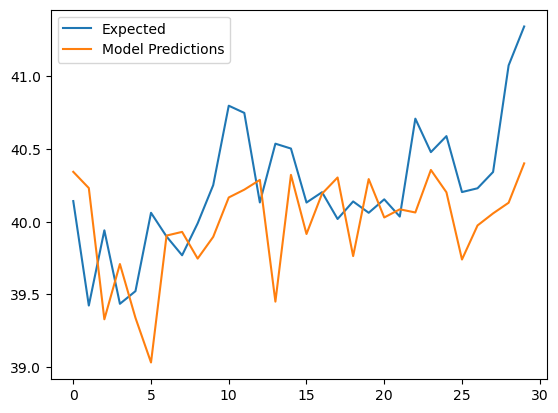

2018-04-19 00:00:00 to  2018-05-31 00:00:00
Mean Absolute error: 0.670


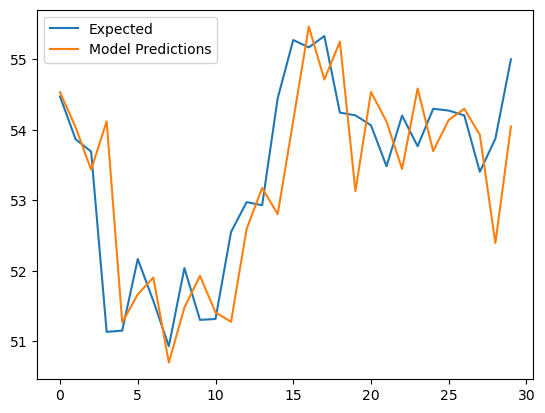

2019-11-26 00:00:00 to  2020-01-09 00:00:00
Mean Absolute error: 0.941


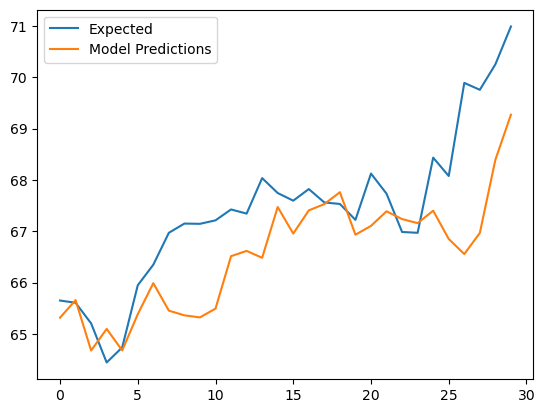

2021-07-08 00:00:00 to  2021-08-18 00:00:00
Mean Absolute error: 1.841


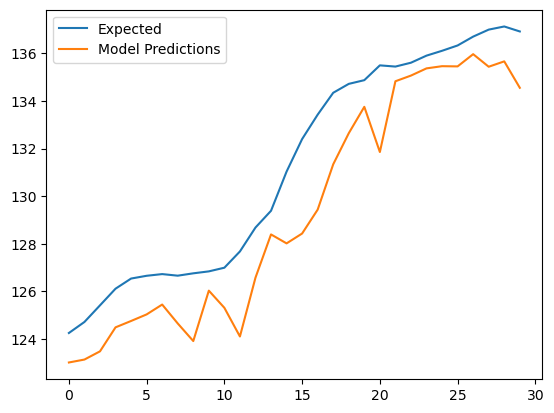

2023-02-15 00:00:00 to  2023-03-29 00:00:00
Mean Absolute error: 3.054


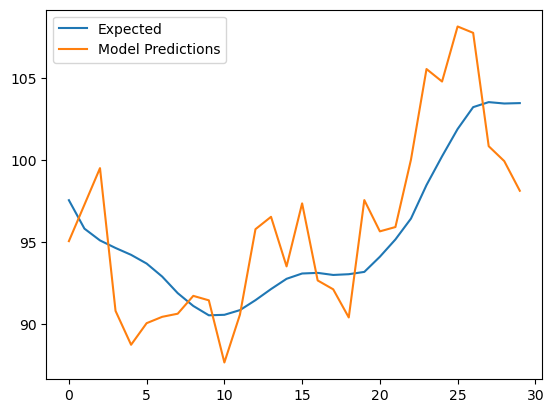

In [9]:
reload(helper)
mae = [None]*5
y = [None]*5
ypred = [None]*5
for i in range(5):
    mae[i], y[i], ypred[i] = helper.walk_forward_validation(data_split[i].values,30)
    print(f'{data_split[i].index[-30]} to  {data_split[i].index[-1]}')
    print(f"Mean Absolute error: {mae[i]:.3f}")
    plt.plot(y[i], label='Expected')
    plt.plot(ypred[i], label='Model Predictions')
    plt.legend()
    plt.show()

In [10]:
average_mae = sum(mae) / 5
print(f"Average Mean Absolute Error: {average_mae:.3f}%")

Average Mean Absolute Error: 1.380%


## Adjusted Close Plot for entire dateset this is the target feature

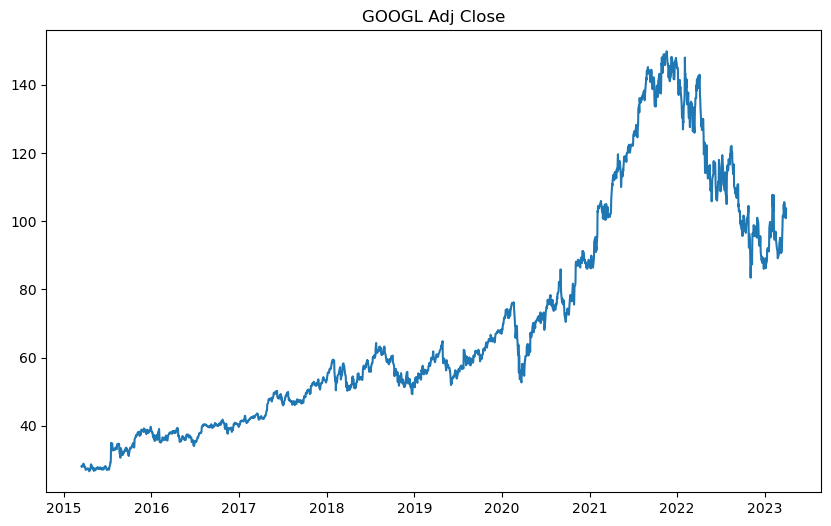

In [11]:
#Display Adjusted close data
plt.figure(figsize=(10,6))
plt.plot(data.index, data["Adj Close"])
plt.title(f"{ticker_symbol} Adj Close")
plt.show()

## Use model to make 5 day future prediction

In [12]:
#data is the previous day and befores lag values trying to predict todays values
#so to predict tomorrow we copy today on to the end of the data set then run the model for the last day 
#to continue making predictions place your prediction in the last rows target then repeat above steps
predictions = list()

full_data = data

#full_data = data_split[2]
#data_target = full_data['Adj Close'].drop(full_data.head(5).index)
#full_data = helper.series_to_supervised(full_data,5,0)
#full_data['target'] = data_target

#add next day
full_data = full_data.append(full_data.iloc[-1])

for i in range(5):
    data_target = full_data['Adj Close'].drop(full_data.head(5).index)
    pred_data = helper.create_lags(full_data,5,0)
    pred_data['target'] = data_target
    mae, y, ypred = helper.walk_forward_validation(pred_data.values,1)
    predictions.append(ypred[-1])
    
    full_data = full_data.append(full_data.iloc[-1])
    full_data['Adj Close'].iloc[-1] = ypred[-1]
    

print(predictions)


C:\Users\darri\AppData\Local\Temp\ipykernel_23984\1034356034.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.iloc[-1])
C:\Users\darri\AppData\Local\Temp\ipykernel_23984\1034356034.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.iloc[-1])
C:\Users\darri\AppData\Local\Temp\ipykernel_23984\1034356034.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.iloc[-1])
C:\Users\darri\AppData\Local\Temp\ipykernel_23984\1034356034.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.il

[101.26319, 102.28069, 102.367165, 102.19561, 102.63678]


C:\Users\darri\AppData\Local\Temp\ipykernel_23984\1034356034.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.iloc[-1])


In [13]:
print(predictions)

[101.26319, 102.28069, 102.367165, 102.19561, 102.63678]


## Retrieve Actual Data for 5 predicted days

In [14]:
x = pdr.get_data_yahoo(ticker_symbol, start=end_date, end=yesterday)
x.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-20,103.910004,106.250000,103.870003,105.290001,105.290001,27820800
2023-04-21,105.470001,106.000000,104.779999,105.410004,105.410004,25784600
2023-04-24,105.489998,106.629997,104.699997,105.970001,105.970001,23542800
2023-04-25,105.830002,106.690002,103.839996,103.849998,103.849998,46664100
2023-04-26,104.919998,106.349998,102.629997,103.709999,103.709999,53347600


In [15]:
final = pdr.get_data_yahoo(ticker_symbol, start=end_date, end=yesterday)
final = final.head(5)
final['Adj Close Pred'] = ''
for i in range(len(predictions)):
    final['Adj Close Pred'] = predictions
final = final[['Adj Close','Adj Close Pred']]

final['Prediction Error'] = ((final['Adj Close'] - final['Adj Close Pred']) / final['Adj Close']) * 100

[*********************100%***********************]  1 of 1 completed


C:\Users\darri\AppData\Local\Temp\ipykernel_23984\4003253331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['Adj Close Pred'] = ''
C:\Users\darri\AppData\Local\Temp\ipykernel_23984\4003253331.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['Adj Close Pred'] = predictions


## Compare Predictions to Real World Values

In [16]:
final

,Adj Close,Adj Close Pred,Prediction Error
Date,,,
2023-04-03,104.360001,101.263191,2.967429
2023-04-04,104.720001,102.280693,2.329362
2023-04-05,104.470001,102.367165,2.012862
2023-04-06,108.419998,102.195610,5.740996
2023-04-10,106.440002,102.636780,3.573114


While 2% error may not seem terrible it is a 2% error margin per day meaning that a 5 day prediction has a potential error margin of roughly 10%